# 0.0 IMPORTS

In [1]:
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns
import math
import inflection
import datetime
import matplotlib.gridspec as gridspec
from itertools import product as prod
from collections import defaultdict
import pickle

from IPython.core.display  import HTML
from IPython.display       import Image

from scipy import stats as ss
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
home_path = "/home/marcos/Documentos/comunidade_DS/DataScience_em_Producao/DataScience_Em_Producao/marcos/"

In [3]:
df_sales_raw = pd.read_csv(home_path + 'data/train.csv', low_memory=False)
df_store_raw = pd.read_csv(home_path + 'data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descricao dos Dados

In [4]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
df1 = df_raw.copy()

O problema: a diretoria da loja deseja fazer uma previsão das vendas em cada uma das lojas pelas próximas seis semanas.

Os CEOs desejam fazer uma reforma nestas lojas e querem saber quanto eles investirão em cada loja.

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers',\
            'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',\
            'StoreType', 'Assortment', 'CompetitionDistance',\
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',\
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',\
            'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = map(snakecase, cols_old)

df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

The amounts of NAs in the columns "competition_open_since_month" and "competition_open_since_year" are equal. This may suggest, as considered below, that there was already a competitor in the neighborhood when the store opened.

The NAs in "competition_distance" will be treated considering that the nearest competitor is far away. Some NAs in this column may occur in rows where there are also NAs in the columns described above, and they are being treated differently. This hypothesis may be reviewed in the next round of CRISP.

To treat the NAs in "promo2_since_", I will first try to correlate them with the 0s in "promo2".

## 1.5 FIllout NA

In [11]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
177246,1077,1,2015-02-23,3428,429,1,0,0,0,a,a,3750.0,11.0,2001.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec"


In [12]:
df1_no_promo2 = df1[df1['promo2'] == 0]
df1_no_promo2.shape

(508031, 18)

In [13]:
df1_no_promo2[['promo2_since_week', 'promo2_since_year', 'promo_interval']].isna().sum()

promo2_since_week    508031
promo2_since_year    508031
promo_interval       508031
dtype: int64

The NAs in "promo2_since_week", "promo2_since_year" and "promo_interval" occur when the store did not participate in the consecutive promotion. I will take the maximum value in "date" and consider that the store participate in the consecutive promotion since that moment.

In [14]:
df1['date'].max()

Timestamp('2015-07-31 00:00:00')

In [15]:
df1['date'].max().week

31

In [16]:
df1['date'].max().year

2015

The maximum of "competition_distance" is also necessary.

In [17]:
df1['competition_distance'].max()

75860.0

In [18]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month\
                                                if math.isnan(x['competition_open_since_month'])\
                                                else x['competition_open_since_month'], axis=1)


#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year\
                                               if math.isnan(x['competition_open_since_year'])\
                                               else x['competition_open_since_year'], axis=1)


#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: 31 if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#promo2_since_year
'''
Same as above
'''
df1['promo2_since_year'] = df1.apply(lambda x: 2015 if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

The hypothesis made to fill the NA in the columns 'competition_open_since' and 'promo2_since' may decrease the accuracy of the model. This must be checked after the first run of the estimator afterwards

The NA data in 'promo_interval' is filled with 0s. Column 'month_map' informs the month of the first sale in the store and column 'is_promo' compares this month with the months when promotions occurred. If the first sale occurred during a promotion, df1['is_promo'] == 1. Else, df1['is_promo'] == 0.

In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [23]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [24]:
display(num_attributes.sample(2))
display(cat_attributes.sample(2))

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
103529,950,4,7401,727,1,1,0,8460.0,11,1994,0,31,2015,0
769906,227,6,3552,324,1,0,0,2370.0,8,2013,0,31,2015,0


,state_holiday,store_type,assortment,promo_interval,month_map
900792,0,d,c,"Jan,Apr,Jul,Oct",Apr
338288,0,a,a,0,Sep


### 1.7.1 Numerical Attributes

In [25]:
num_desc = num_attributes.describe()
num_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()), columns=['range']).T
num_skew = pd.DataFrame(num_attributes.skew(), columns=['skew']).T
num_kurt = pd.DataFrame(num_attributes.kurt(), columns=['kurtosis']).T

num_stat = pd.concat([num_desc, num_range, num_skew, num_kurt]).T.drop(columns=['count'])
num_stat

,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
store,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,-7.235657,124.071304


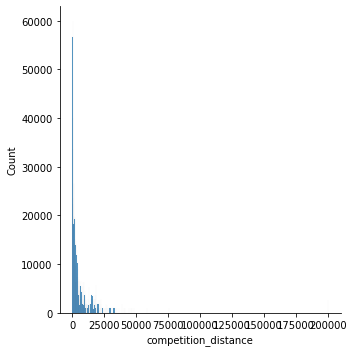

In [26]:
sns.displot(df1['competition_distance'].T);

### 1.7.2 Categorical Attributes

In [27]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

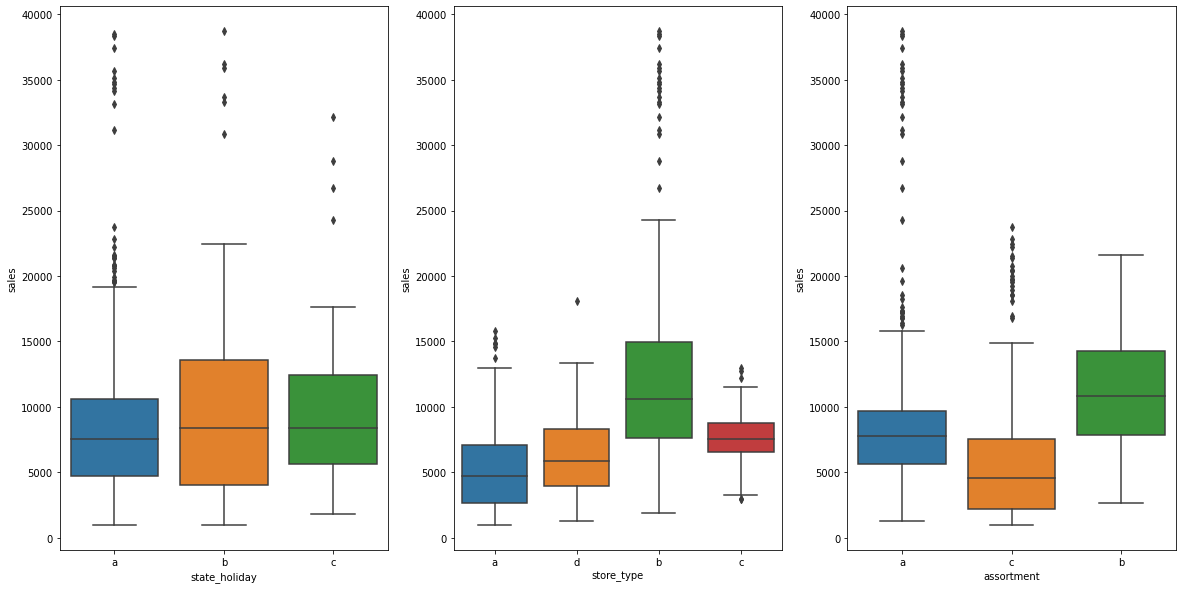

In [28]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(20, 10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 );

# 2.0 FEATURE ENGINEERING

In [29]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

O mapa mental exibe os agentes que influenciam o fenômeno em questão, e os atributos destes agentes. Ele não se limita aos dados que foram coletados.

In [30]:
'''
No centro, o fenômeno. No primeiro nível, os agentes. No segundo nível, os atributos de cada agente.
'''
Image('img/mind_map_hypothesis_2.png')

FileNotFoundError: No such file or directory: 'img/mind_map_hypothesis_2.png'

FileNotFoundError: No such file or directory: 'img/mind_map_hypothesis_2.png'

<IPython.core.display.Image object>

## 2.2. Criação das Hipóteses

As hipóteses utilizam os agentes do mapa mental e as features apresentadas nos dados.

### 2.2.1 Hipóteses Lojas

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com maior número de competidores deveriam vender menos.

**6.** Lojas com mais promoções deveriam vender mais.

**7.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõem mais produtos na vitrine deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais.

**5.** Produtos com maior estoque deveriam vender mais.

**6.** Produtos em promoção deveriam vender mais.

**7.** Produtos com promoções sazonais deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que fecham em mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses do ano deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas melhor estabelecidas na região deveriam vender mais.

**5.** Lojas com competidores mais antigos deveriam vender menos.

## 2.3 Lista final de hipóteses

Selecionar, dentre as hipóteses, as que se referem a atributos presentes nas features (p/ex, sortimento e competidores, mas não porte ou nr de funcionários).

**Lojas:**

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com maior número de competidores deveriam vender menos.

**3.** Lojas com mais promoções deveriam vender mais.

**Produto**

**4.** Produtos em promoção deveriam vender mais.

**Tempo**

**5.** Lojas que fecham em mais feriados deveriam vender menos.

**6.** Lojas que abrem nos primeiros 6 meses do ano deveriam vender mais.

**7.** Lojas que abrem nos finais de semana deveriam vender mais.

## 2.4 Feature Engineering

In [31]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# year-week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#week of year
df2['week_of_year'] = df2['date'].dt.strftime('%W').astype(int)


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month =x['competition_open_since_month'] , day =1 ), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtragem de Variáveis

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,year_week,week_of_year,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,2015-30,30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,2015-30,30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,2015-30,30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,2015-30,30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,2015-30,30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [34]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 Filtragem das Colunas

In [35]:
#filtrar colunas que serão retiradas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'year_week', 'week_of_year', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

Redefine the datasets containing the numerical and categorical attributes:

# 4.0 Análise Exploratória dos Dados

In [37]:
df4 = df3.copy()

In [38]:
num_attr = df4.select_dtypes(include=['int64', 'float64'])
cat_attr = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise Univariada

### 4.1.1 Response Variable

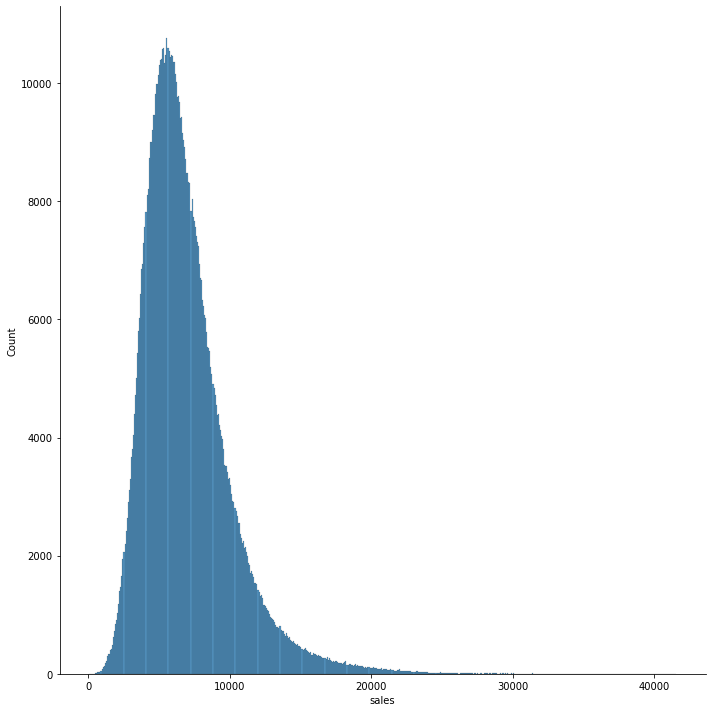

In [39]:
#high kurtosis
sns.displot(df4['sales'], height=10);

### 4.1.2 Numerical Variable

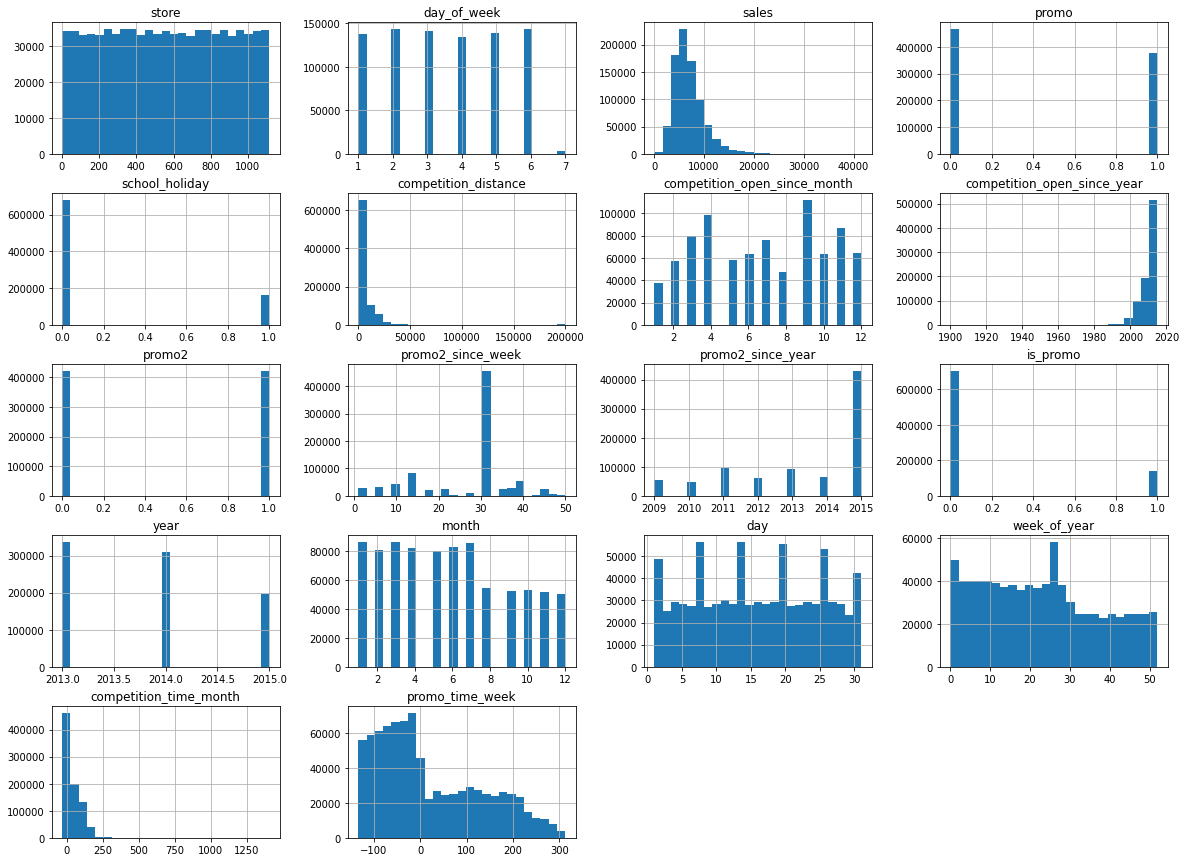

In [40]:
num_attr.hist(figsize=(20,15), bins=25);

### 4.1.3 Categorical Variable

In [41]:
cat_attr.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [42]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [43]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [44]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

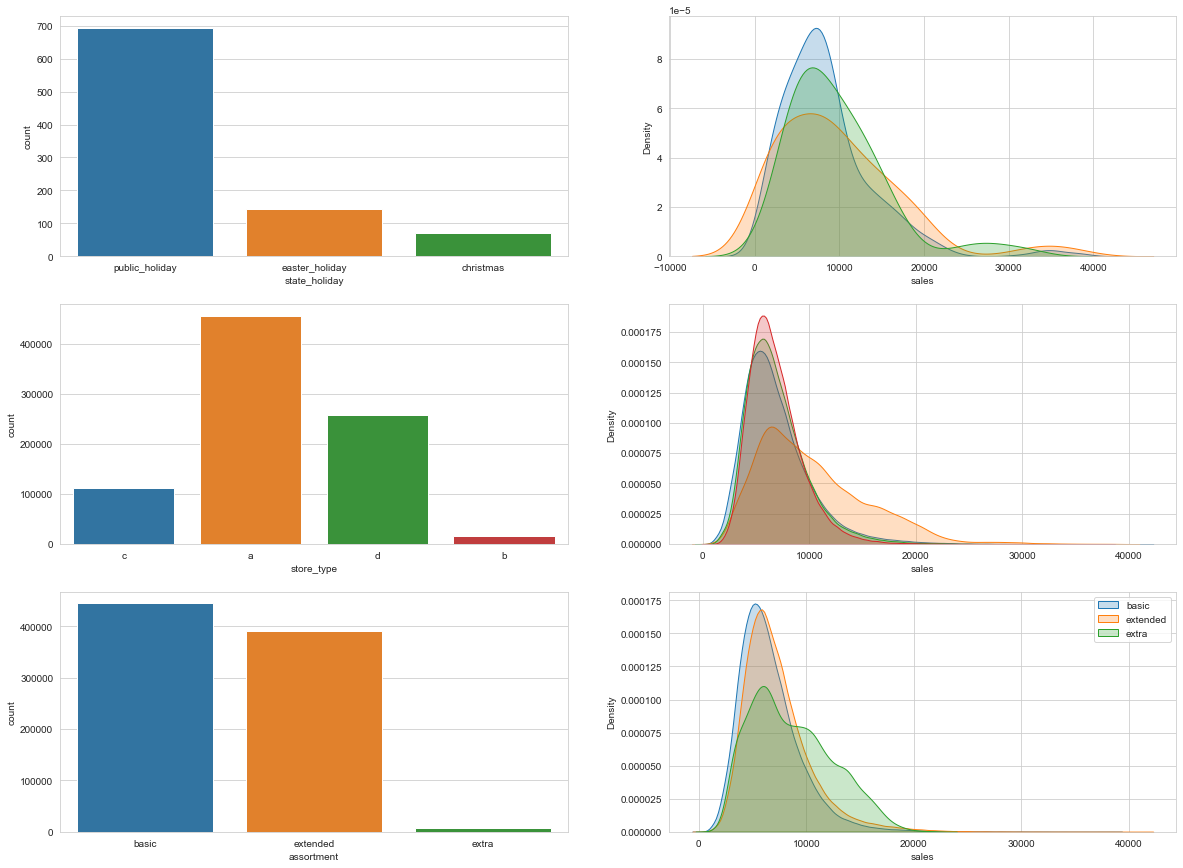

In [45]:
# state_holiday
plt.figure(figsize=(20,15))
a = df4[df4['state_holiday'] != 'regular_day']
sns.set_style('whitegrid')

plt.subplot(3, 2, 1)
sns.countplot(x=a['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);


#store type
plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);


#assortment
plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

plt.legend();
plt.show()

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com maior sortimento vendem menos!

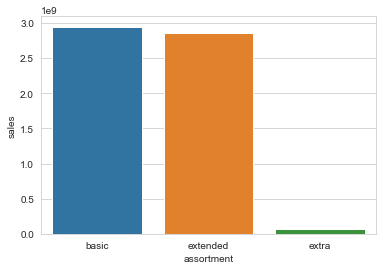

In [46]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

Acompanhar o progresso das vendas ao longo do ano:

In [47]:
aux2 = df4[['week_of_year', 'assortment', 'sales']].groupby(['week_of_year', 'assortment']).sum().reset_index()

aux3 = aux2.pivot(index='week_of_year', columns='assortment', values='sales')
aux3

assortment,basic,extended,extra
week_of_year,,,
0,30492897,29464970,875646
1,76282675,71089388,1407578
2,60834559,57422765,1430814
3,67293770,62278188,1449332
4,64942614,61506525,1487982
5,77989384,72724570,1582548
6,57494708,55055182,1523219
7,74257078,69354111,1536181
8,59180518,56733799,1534406


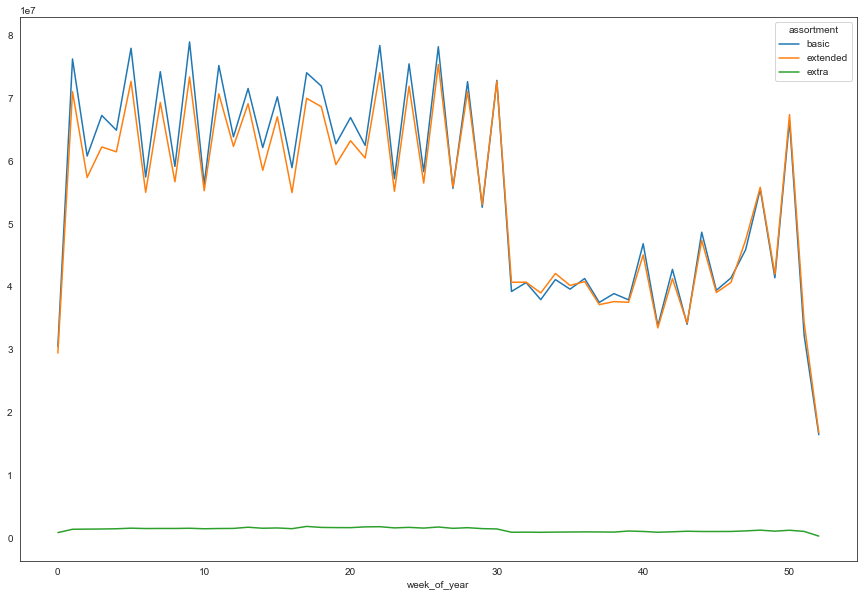

In [48]:
sns.set_style(style='white');
aux3.plot(figsize=(15,10));

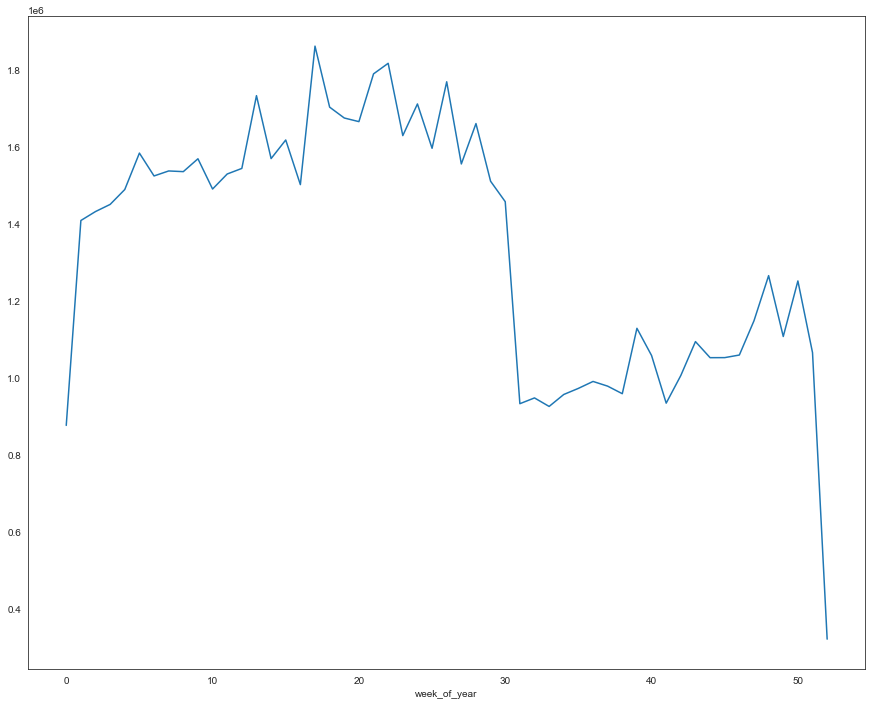

In [49]:
aux4 = aux3['extra']
aux4.plot(figsize=(15,12));

### H2. Lojas com maior número de competidores deveriam vender menos.

**FALSA** Lojas com competidores próximos vendem mais!

**Outra hipótese** Lojas sem competidores ficariam isoladas, e portanto, não atrairiam consumidores?

In [50]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

In [51]:
bins = list(np.arange(0, 200000, 8000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

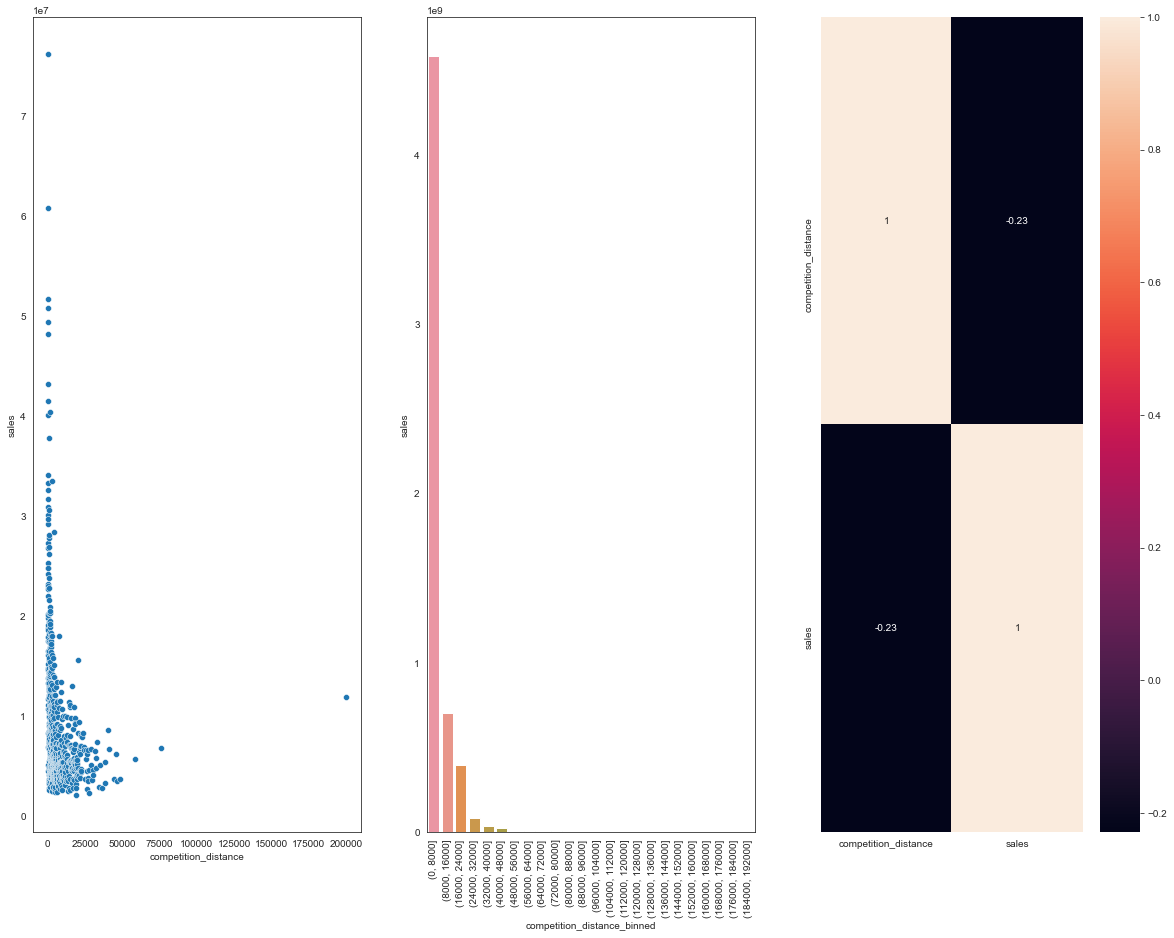

In [52]:
plt.figure(figsize=(20,15))
sns.set_style('white')

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

A correlação negativa indica que, quanto mais distante está o concorrente, menor a quantidade de vendas. O valor absoluto 0,23 indica que a correlação entre distância e quantidade de vendas é pequena.

### H3. Lojas com competidores há mais tempo deveriam vender mais.

Esta hipótese diz que o fato de o competidor não ser mais "novidade" deveria aumentar as vendas da loja. Os dados desmentem esta hipótese, ou seja, ela é **FALSA**.

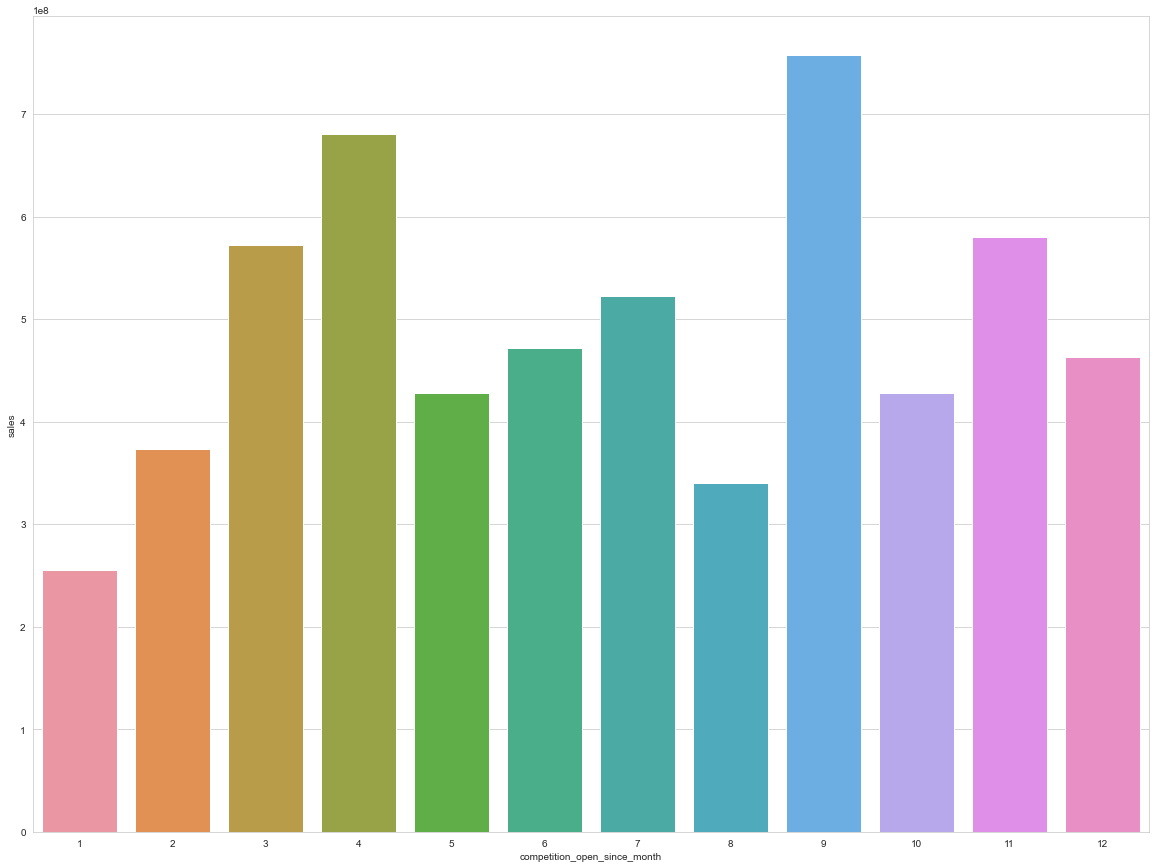

In [53]:
aux1 = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').sum().reset_index()

plt.figure(figsize=(20,15))
sns.set_style('whitegrid')

sns.barplot(x='competition_open_since_month', y='sales', data=aux1);

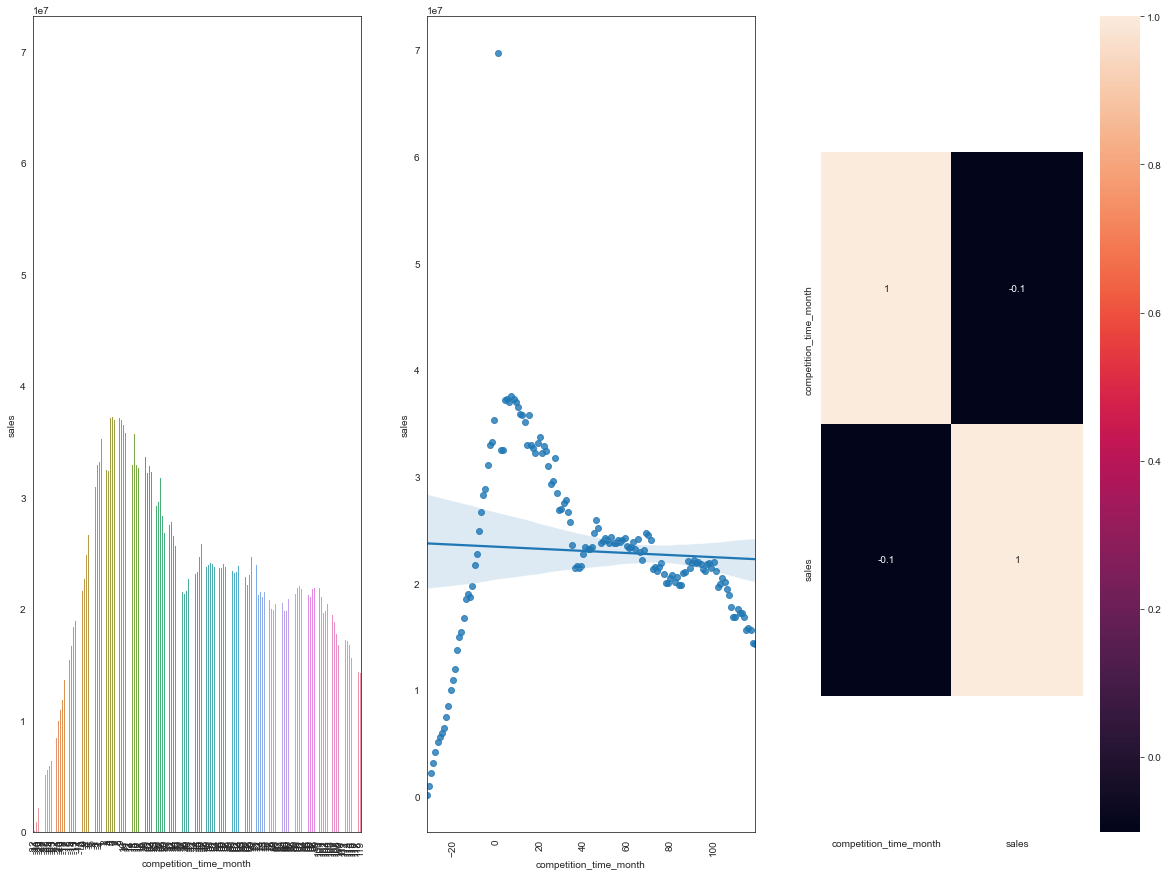

In [54]:
aux2 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux3 = aux2[(aux2['competition_time_month'] < 120) & (aux2['competition_time_month'] != 0)]
plt.figure(figsize=(20,15))
sns.set_style('white')

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux2.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais

**Falsa** Lojas com promoção ativa por mais tempo vendem mais somente durante um certo período. O efeito da promoção diminui após um certo período.

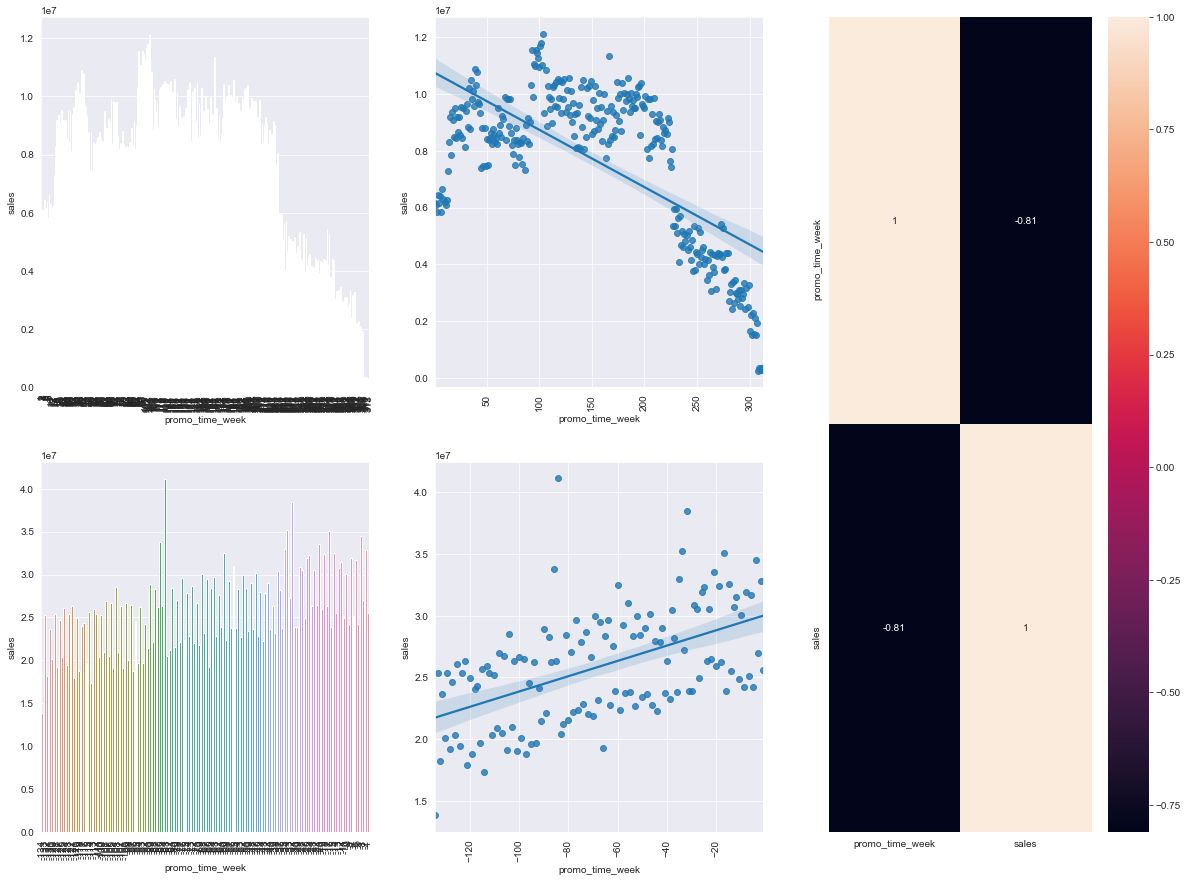

In [55]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#diferenciar a promoção regular da estendida

plt.figure(figsize=(20,15))
sns.set_style('darkgrid')

grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção estendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção estendida
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção regular
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais</s>

Será avaliado no próximo ciclo do CRISP (até então, a análise da hipótese anterior invalida esta).

### H6. Lojas com mais promoções deveriam vender mais

**Falsa** Lojas com mais promoções consecutivas vendem tanto quanto as lojas que só fazem as promoções tradicionais.

In [56]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


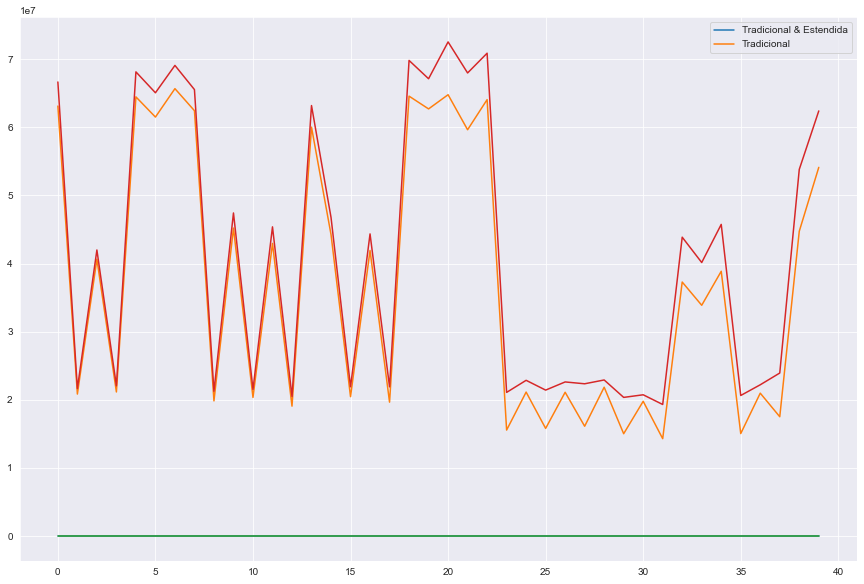

In [57]:
#sns.set_style('white')
aux1 = df4[(df4['promo'] == 1) & ((df4['promo2'] == 1))][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
ax = aux1.plot(figsize=(15,10));

aux2 = df4[(df4['promo'] == 1) & ((df4['promo2'] == 0))][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Estendida', 'Tradicional']);

### H7 Lojas abertas durante o feriado de natal deveriam vender mais
**Falsa** O feriado de natal é o que tem menores vendas

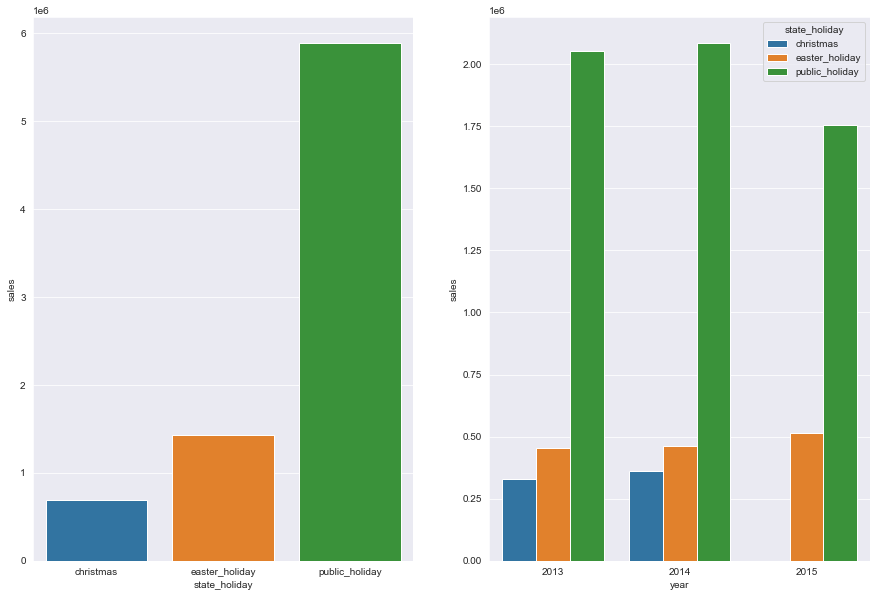

In [58]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

### H8 Lojas deveriam vender mais ao longo dos anos
**Falsa** Lojas vendem menos ao longo dos anos

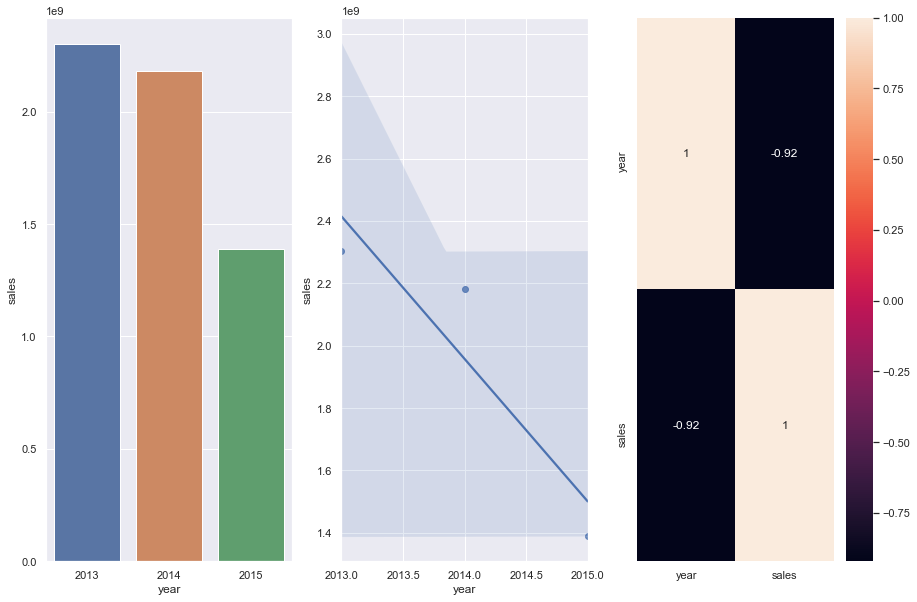

In [59]:
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()

sns.set_theme()
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);
#plt.xticks(rotation=90);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 Lojas deveriam vender mais no segundo semestre
**Falsa** Lojas vendem menos no segundo semestre do ano

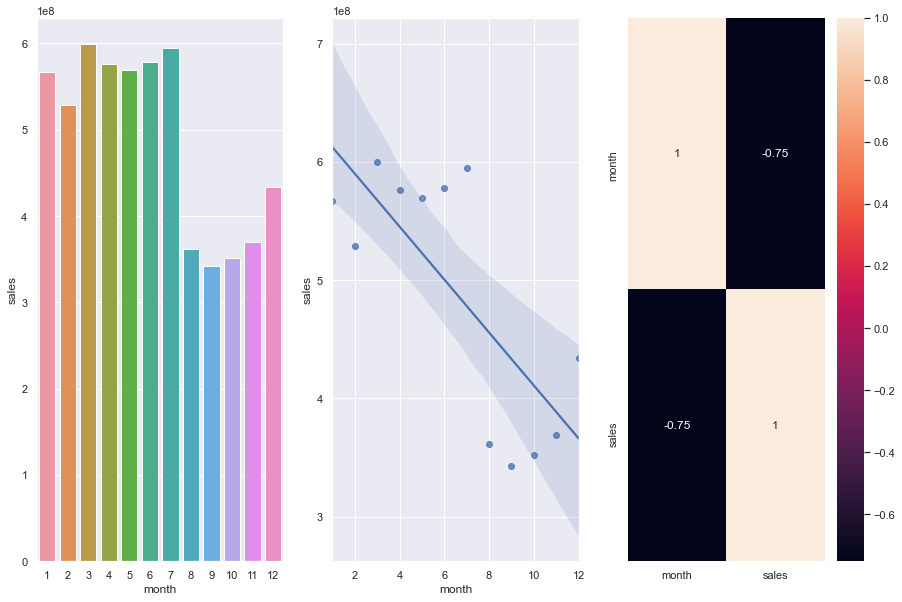

In [60]:
aux1 = df4[['month', 'sales']].groupby(['month']).sum().reset_index()

plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10 Lojas deveriam vender mais depois do dia 10 de cada mês
**Verdadeira** As lojas vendem mais depois do dia 10 de cada mês. Porém, a quantidade de vendas por dia diminui ao longo do mês.

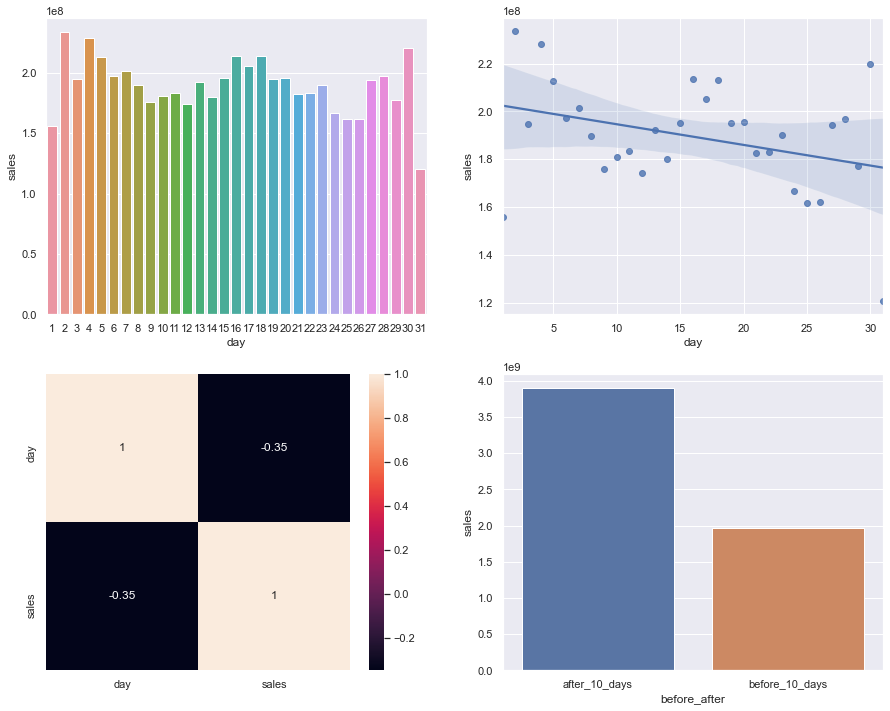

In [61]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()

plt.figure(figsize=(15,12))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);


plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')

aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H11 Lojas deveriam vender menos nos finais de semana
**Verdadeira** Lojas vendem menos nos finais de semana

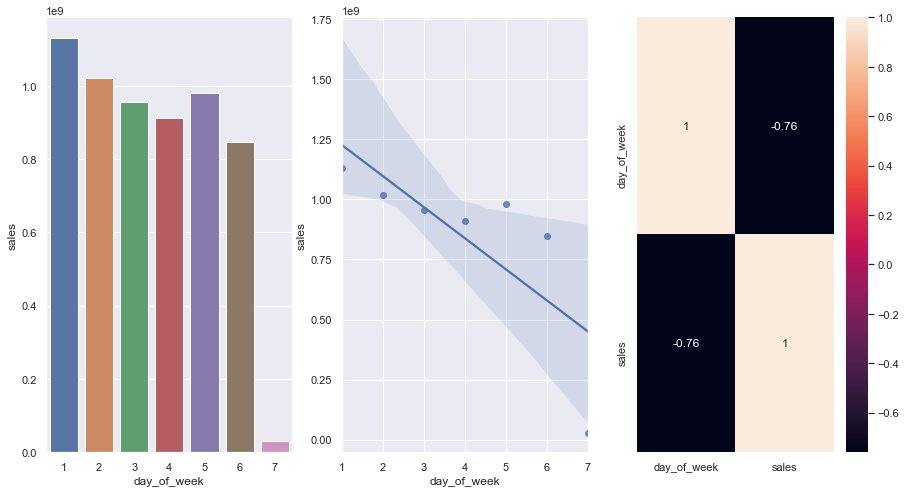

In [62]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.figure(figsize=(15,8))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12 Lojas deveriam vender menos durante os feriados escolares
**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

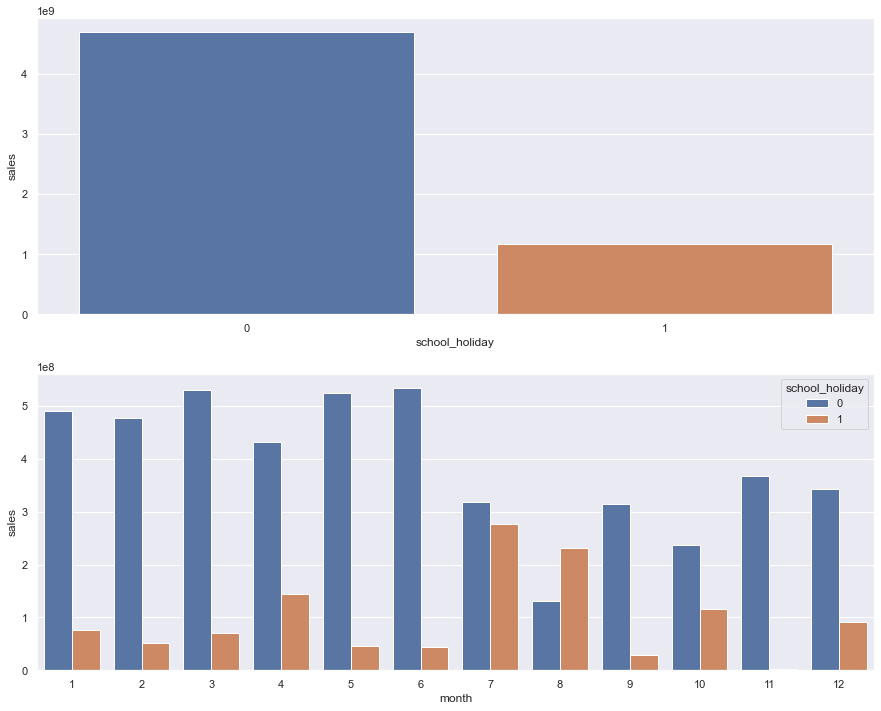

In [63]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(15,12))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday');

## 4.3 Análise Multivariada

### 4.3.1 Variáveis numéricas

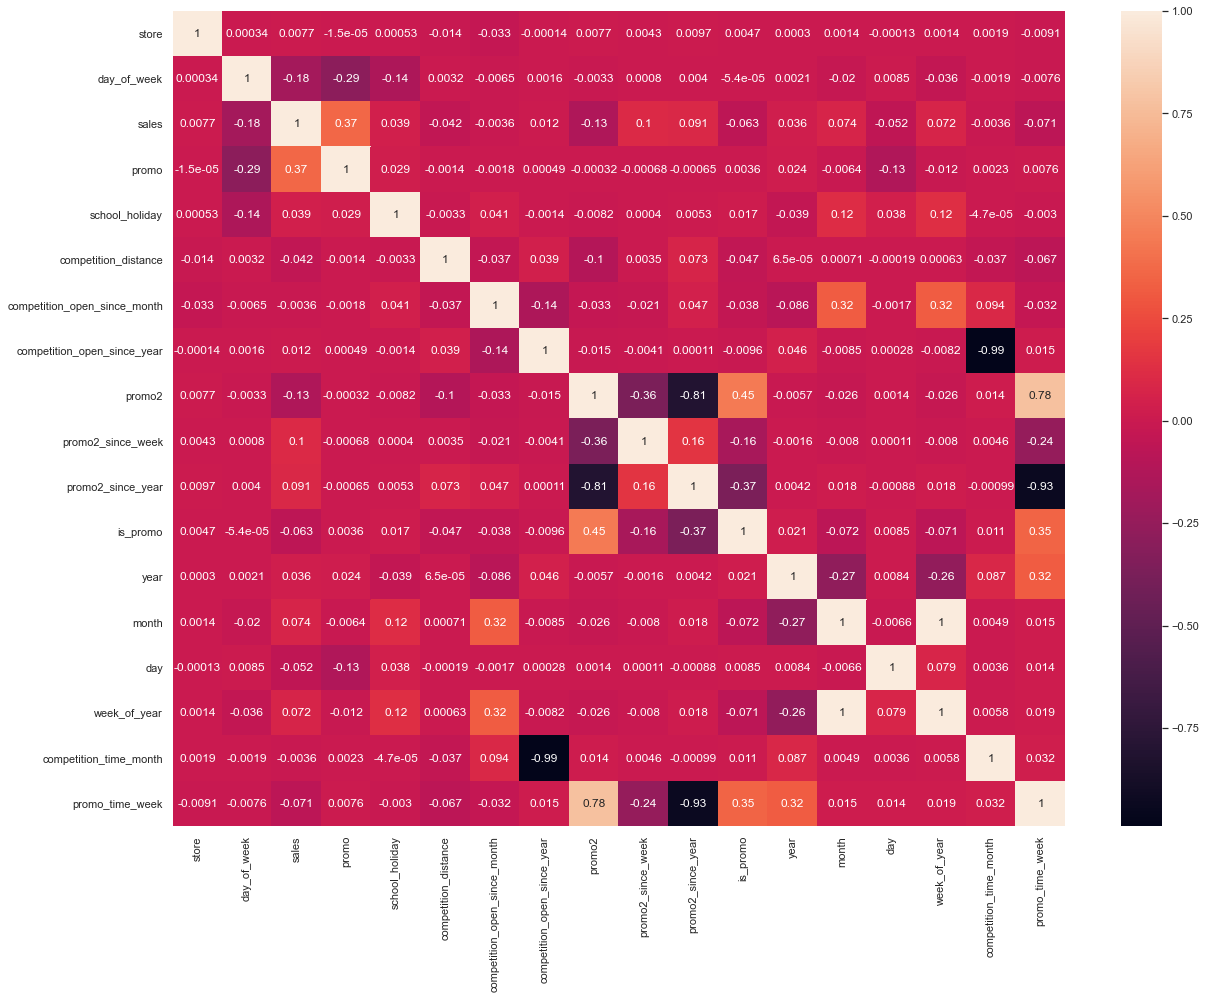

In [64]:
correlation = num_attr.corr(method='pearson')
plt.figure(figsize=(20,15))
sns.heatmap(correlation, annot=True);

### 4.3.2 Variáveis Categóricas

In order to calculate the correlation among the categorical variables, the Pearson method is not adequate. Instead, we are going to use Cramér's V.

I will calculate the correlation between all pairs of variables among 'state_holiday', 'store_type' and 'assortment'.

The correlation will be calculated using the chi2_contigency function from the scipy.stats module.

This function receives, as arguments, the frequencies of two variables. These frequencies will be calculated using the crosstab function from pandas.

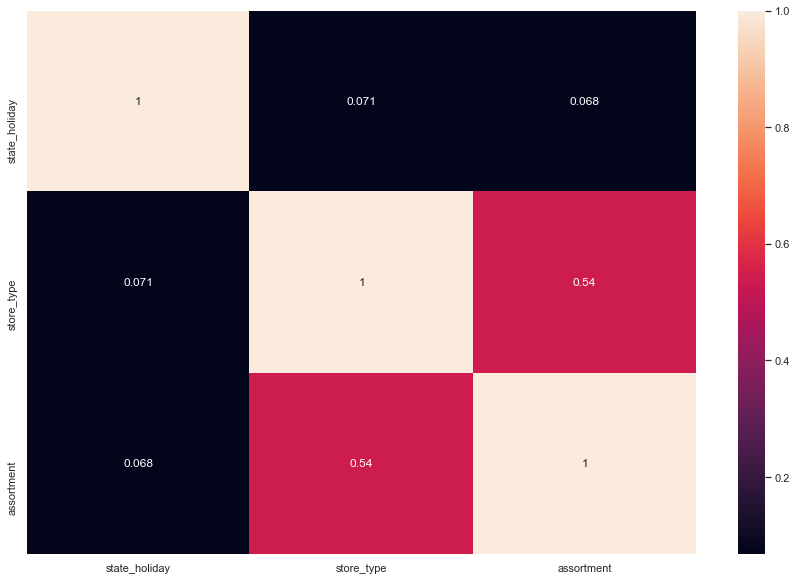

In [65]:
indexes = ['state_holiday', 'store_type', 'assortment']

#for scalability, I will create a function that returns Cramér's V correlation:

def cat_corr(x, y):
    '''Cross frequencies'''
    cont_mat = pd.crosstab(x, y).to_numpy()
    
    n = cont_mat.sum()
    r, k = cont_mat.shape
    
    '''chi square statistics'''
    chi2 = ss.chi2_contingency(cont_mat)[0]
    
    '''Corrected variables to compensate for bias:'''
    chi2corr = max(0, (chi2/n) - (k - 1)*(r - 1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    
    '''Cramérs V correlation'''''
    cramer_v = np.sqrt((chi2corr)/(min(k_corr-1, r_corr-1)))
    return cramer_v


d = defaultdict(list)
#d = {}
for x, y in prod(indexes, repeat=2):
    d[x].append(cat_corr(cat_attr[x],cat_attr[y]))

a = pd.DataFrame(d, index=indexes)

plt.figure(figsize=(15,10))
sns.heatmap(a, annot=True);

# 5.0 Data Preparation

In [66]:
df5 = df4.copy()

## 5.1 Normalization

Normalization works better for normal distributions. The univariate EDA for the numerical variables shows that none of them are normal, therefore the normalization will be skipped. The preparation will start with the rescaling in the next subsection.

## 5.2 Rescaling

In [67]:
num_attr

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,30,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,30,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,30,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,30,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,30,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.0,9,2006,0,31,2015,0,2013,1,1,0,77,-134
1016827,733,2,10765,0,1,860.0,10,1999,0,31,2015,0,2013,1,1,0,161,-134
1016863,769,2,5035,0,1,840.0,1,2013,1,48,2012,1,2013,1,1,0,0,6
1017042,948,2,4491,0,1,1430.0,1,2013,0,31,2015,0,2013,1,1,0,0,-134


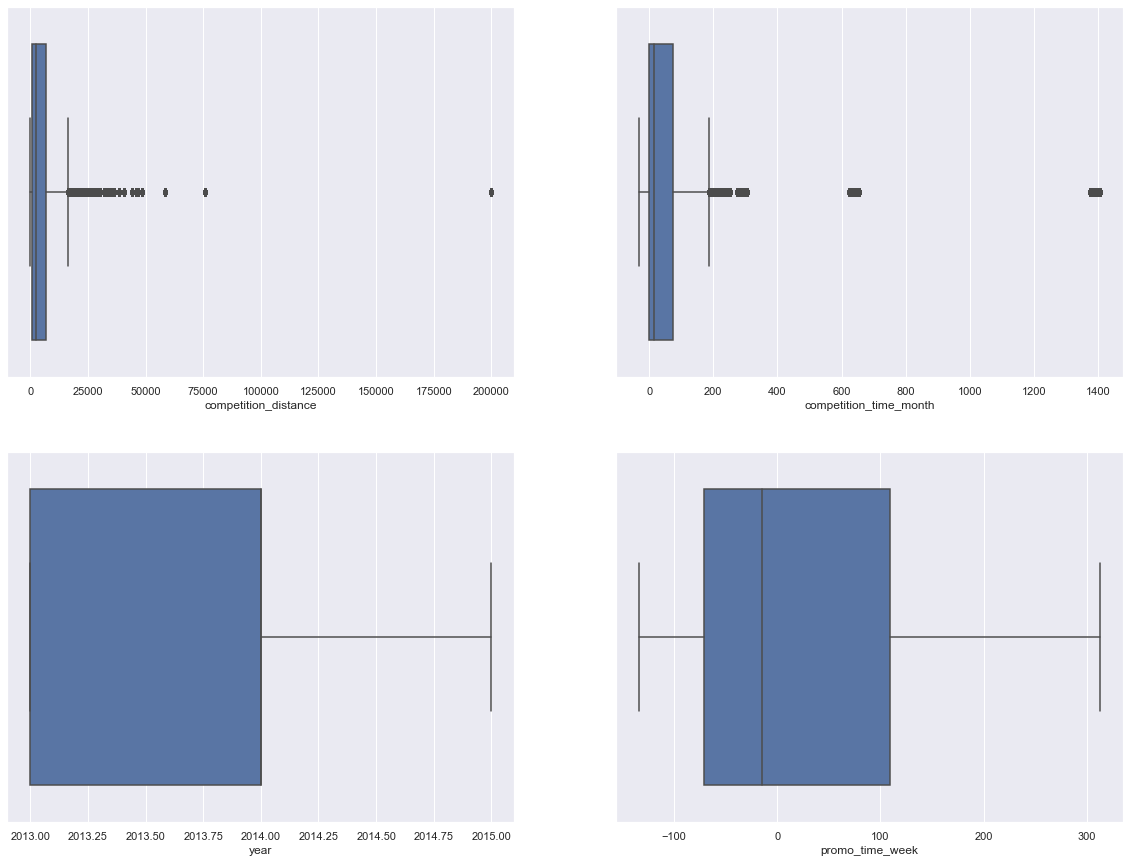

In [68]:
plt.figure(figsize=(20,15))
sns.set_style('darkgrid')

plt.subplot(2, 2, 1)
sns.boxplot(x=num_attr['competition_distance']);

plt.subplot(2, 2, 2)
sns.boxplot(x=num_attr['competition_time_month']);

plt.subplot(2, 2, 3)
sns.boxplot(x=num_attr['year']);

plt.subplot(2, 2, 4)
sns.boxplot(x=num_attr['promo_time_week']);

There only attribute without relevant outliers is the 'year'. This will be rescaled using MinMaxScaler. All the other attributes will be rescaled using RobustScaler.

In [69]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# promo_time_week
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [70]:
cat_attr.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [71]:
# state_holiday: "One-hot" encoding
df5 = pd.get_dummies(df5, prefix='state_holiday', columns=['state_holiday'])

# store_type: the types will be converted to numerical labels
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
df5['assortment'] = df5['assortment'].map({'basic':1, 'extra':2, 'extended':3})

### 5.3.2 Response Variable Transformation

Apply a log transformation on the response variable to obtain a variable whose distribution is closer to a normal distribution.

In [72]:
df5['sales'] = df5['sales'].apply(lambda x: np.log1p(x))

### 5.3.3 Nature Transformation

The variables below are cyclic. A trigonometric transformation will be applied to each of them in order to input the cyclicity.

In [73]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,year_week,week_of_year,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,2015-30,30,2008-09-01,0.918919,2015-07-27,0.083333,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,2015-30,30,2007-11-01,1.054054,2010-03-22,1.633333,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,2015-30,30,2006-12-01,1.202703,2011-03-28,1.338889,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,2015-30,30,2009-09-01,0.743243,2015-07-27,0.083333,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,2015-30,30,2015-04-01,-0.162162,2015-07-27,0.083333,0,0,0,1


In [74]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day - assume all months have 30 days
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [75]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456,-0.974928,-0.222521


## 5.4 Data dimensions

In [76]:
df5.shape

(844338, 36)

In [77]:
df5_1 = df5.iloc[0:300000].copy()
df5_2 = df5.iloc[300000:600000].copy()
df5_3 = df5.iloc[600000:].copy()

In [78]:
df5_1.shape

(300000, 36)

In [79]:
df5_2.shape

(300000, 36)

In [80]:
df5_3.shape

(244338, 36)

## 5.5 Export DataFrame

In [81]:
df5_1.to_pickle(home_path + 'data_in_progress/df5_1.pkl', protocol=4)
df5_2.to_pickle(home_path + 'data_in_progress/df5_2.pkl', protocol=4)
df5_3.to_pickle(home_path + 'data_in_progress/df5_3.pkl', protocol=4)